<a href="https://colab.research.google.com/github/WahyuKhairi06/TextMining_WahyuKhairi_2311531009/blob/main/Tugas_2_Text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Library**

In [10]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import spacy

# **Prepocessing**

read dataset


In [11]:
# Baca dataset
df = pd.read_csv("Pendidikan.csv")

# Lihat 10 data teratas
print(df.head(10))


   conversation_id_str                      created_at  favorite_count  \
0  1969548061644112360  Sat Sep 20 23:43:44 +0000 2025               0   
1  1968992819357376959  Sat Sep 20 23:36:32 +0000 2025               0   
2  1968992819357376959  Sat Sep 20 23:35:23 +0000 2025               0   
3  1969327410895110617  Sat Sep 20 23:35:08 +0000 2025               0   
4  1969419111789969715  Sat Sep 20 23:32:36 +0000 2025               0   
5  1969545224050364571  Sat Sep 20 23:32:28 +0000 2025              70   
6  1969369069918044483  Sat Sep 20 23:32:14 +0000 2025               0   
7  1969544856923226387  Sat Sep 20 23:31:45 +0000 2025               0   
8  1969544472855003573  Sat Sep 20 23:29:42 +0000 2025               0   
9  1968958537792418251  Sat Sep 20 23:26:48 +0000 2025               0   

                                           full_text               id_str  \
0  Kepala sekolahnya disurati dinas pendidikan ko...  1969548061644112360   
1  @orang_tersesat @kompascom B

In [12]:
df.shape

(80, 15)

(80, 15)

In [13]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Lowercasing
df['cleaned_text'] = df['full_text'].str.lower()

# Hapus angka, tanda baca, dan karakter khusus
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Tokenisasi
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

# Remove stopwords (optional, but common in text cleaning)
stop_words = set(stopwords.words('english')) # You might want to use Indonesian stopwords if the text is in Indonesian
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Display the first few rows with the new columns
display(df[['full_text', 'cleaned_text', 'tokens']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,full_text,cleaned_text,tokens
0,Kepala sekolahnya disurati dinas pendidikan ko...,kepala sekolahnya disurati dinas pendidikan ko...,"[kepala, sekolahnya, disurati, dinas, pendidik..."
1,@orang_tersesat @kompascom Bahlil Lahadalia pu...,orangtersesat kompascom bahlil lahadalia punya...,"[orangtersesat, kompascom, bahlil, lahadalia, ..."
2,@kompascom @grok dengan kebijakan selama ini a...,kompascom grok dengan kebijakan selama ini apa...,"[kompascom, grok, dengan, kebijakan, selama, i..."
3,@rachardiana_ayu @DianSandiU MDIS adalah lemba...,rachardianaayu diansandiu mdis adalah lembaga ...,"[rachardianaayu, diansandiu, mdis, adalah, lem..."
4,@NenkMonica GANTIKAN DENGAN PENDIDIKAN GRATIS ...,nenkmonica gantikan dengan pendidikan gratis j...,"[nenkmonica, gantikan, dengan, pendidikan, gra..."


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,full_text,cleaned_text,tokens
0,Kepala sekolahnya disurati dinas pendidikan ko...,kepala sekolahnya disurati dinas pendidikan ko...,"[kepala, sekolahnya, disurati, dinas, pendidik..."
1,@orang_tersesat @kompascom Bahlil Lahadalia pu...,orangtersesat kompascom bahlil lahadalia punya...,"[orangtersesat, kompascom, bahlil, lahadalia, ..."
2,@kompascom @grok dengan kebijakan selama ini a...,kompascom grok dengan kebijakan selama ini apa...,"[kompascom, grok, dengan, kebijakan, selama, i..."
3,@rachardiana_ayu @DianSandiU MDIS adalah lemba...,rachardianaayu diansandiu mdis adalah lembaga ...,"[rachardianaayu, diansandiu, mdis, adalah, lem..."
4,@NenkMonica GANTIKAN DENGAN PENDIDIKAN GRATIS ...,nenkmonica gantikan dengan pendidikan gratis j...,"[nenkmonica, gantikan, dengan, pendidikan, gra..."


In [14]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['stemmed'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

print(df[['tokens', 'stemmed']].head())

                                              tokens  \
0  [kepala, sekolahnya, disurati, dinas, pendidik...   
1  [orangtersesat, kompascom, bahlil, lahadalia, ...   
2  [kompascom, grok, dengan, kebijakan, selama, i...   
3  [rachardianaayu, diansandiu, mdis, adalah, lem...   
4  [nenkmonica, gantikan, dengan, pendidikan, gra...   

                                             stemmed  
0  [kepala, sekolah, surati, dinas, didik, korami...  
1  [orangtersesat, kompascom, bahlil, lahadalia, ...  
2  [kompascom, grok, dengan, bijak, lama, ini, ap...  
3  [rachardianaayu, diansandiu, mdis, adalah, lem...  
4  [nenkmonica, ganti, dengan, didik, gratis, jik...  
                                              tokens  \
0  [kepala, sekolahnya, disurati, dinas, pendidik...   
1  [orangtersesat, kompascom, bahlil, lahadalia, ...   
2  [kompascom, grok, dengan, kebijakan, selama, i...   
3  [rachardianaayu, diansandiu, mdis, adalah, lem...   
4  [nenkmonica, gantikan, dengan, pendidikan, gra... 

# **1. BoW (bag of word)**

In [22]:
df['stemmed_text'] = df['stemmed'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['stemmed_text'])

print("Feature names (first 50):", vectorizer.get_feature_names_out()[:50])

Feature names (first 50): ['ad' 'ada' 'adab' 'adalah' 'adil' 'administratif' 'ae' 'aja' 'ajar' 'aje'
 'akal' 'akan' 'akhir' 'akreditasi' 'aktivitas' 'aku' 'akuin' 'akun'
 'akur' 'alfagift' 'alih' 'alokasi' 'already' 'ambil' 'amp' 'anak'
 'anakanak' 'anakogi' 'ancene' 'anchor' 'anda' 'aneh' 'angel' 'anggar'
 'angklung' 'anjing' 'antri' 'apa' 'apakah' 'apalagi' 'apbn' 'apbnnya'
 'aplg' 'apresiasi' 'aptisk' 'arah' 'arti' 'asa' 'asbun' 'atau']


#**2. TF-IDF (Term Frequency – Inverse Document Frequency)**

In [36]:
tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(df['stemmed_text'])

print("Feature names (first 50):", tfidf_vectorizer.get_feature_names_out()[:50])

Feature names (first 50): ['ad' 'ada' 'adab' 'adalah' 'adil' 'administratif' 'ae' 'aja' 'ajar' 'aje'
 'akal' 'akan' 'akhir' 'akreditasi' 'aktivitas' 'aku' 'akuin' 'akun'
 'akur' 'alfagift' 'alih' 'alokasi' 'already' 'ambil' 'amp' 'anak'
 'anakanak' 'anakogi' 'ancene' 'anchor' 'anda' 'aneh' 'angel' 'anggar'
 'angklung' 'anjing' 'antri' 'apa' 'apakah' 'apalagi' 'apbn' 'apbnnya'
 'aplg' 'apresiasi' 'aptisk' 'arah' 'arti' 'asa' 'asbun' 'atau']


# **3. Word2Vec**

In [37]:
model = Word2Vec(sentences=df['tokens'], vector_size=50, window=5, min_count=1, workers=4)

# Display the vocabulary size
print("Vocabulary size:", len(model.wv.index_to_key))

# You can access the vector for a word like this:
print("Vector for 'pendidikan':", model.wv['pendidikan'])

# You can find similar words like this:
print("Words similar to 'sekolah':", model.wv.most_similar('sekolah'))

Vocabulary size: 927
Vector for 'pendidikan': [-0.00073679 -0.00049546  0.01138111  0.01816961 -0.02122558 -0.0156355
  0.01546073  0.01991442 -0.01416811 -0.00950206  0.0145129  -0.00535221
 -0.00954695  0.01378398 -0.01148577 -0.00351447  0.00746515  0.00218642
 -0.01923198 -0.02132184  0.01536102  0.01216747  0.01669144  0.00090827
  0.01275639 -0.00512963 -0.00265303  0.01086242 -0.01832447 -0.00639868
 -0.01533069 -0.00234362  0.01894058 -0.01452647 -0.007079   -0.00124576
  0.01738861 -0.01134516  0.00014255 -0.01207134 -0.01617563  0.00932809
 -0.01887754 -0.00857774  0.00464572 -0.00073084 -0.0158703   0.01854317
  0.01123965  0.01911709]
Words similar to 'sekolah': [('outputnya', 0.5351881980895996), ('asbun', 0.3795631229877472), ('bersama', 0.37836754322052), ('gz', 0.36856773495674133), ('didiknya', 0.3657645881175995), ('terbayar', 0.364006906747818), ('tanggung', 0.34084352850914), ('langkah', 0.32265546917915344), ('httpstcoshktkkhb', 0.3214566707611084), ('community', 0

# **4. GloVe**

In [52]:
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    print("Downloading en_core_web_md model...")
    from spacy.cli import download
    download("en_core_web_md")
    nlp = spacy.load("en_core_web_md")


# Function to get the GloVe vector for a text
def get_glove_vector(text):
    # Process the text with the spaCy model
    doc = nlp(text)
    return doc.vector

# Apply the function to the 'stemmed_text' column to get GloVe embeddings for each document
df['glove_embeddings'] = df['stemmed_text'].apply(get_glove_vector)

# Display the shape of the resulting embeddings for the first few rows
print("Shape of GloVe embeddings for the first 5 documents:")
for i in range(min(5, len(df))):
    print(f"Document {i}: {df['glove_embeddings'][i].shape}")

# # You can access the vector for a specific document like this:
# print("\nGloVe embedding for the first document:", df['glove_embeddings'][0])

Shape of GloVe embeddings for the first 5 documents:
Document 0: (300,)
Document 1: (300,)
Document 2: (300,)
Document 3: (300,)
Document 4: (300,)


#**Analisa**

In [24]:
# Display the first 10 rows of the BoW matrix
display(bow_df.head(10))

,ad,ada,adab,adalah,adil,administratif,ae,aja,ajar,aje,...,wisuda,xplshx,ya,yah,yakin,yang,yg,yoora,yuk,zonauang
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [25]:
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the first 10 rows of the TF-IDF matrix
display(tfidf_df.head(10))

,ad,ada,adab,adalah,adil,administratif,ae,aja,ajar,aje,...,wisuda,xplshx,ya,yah,yakin,yang,yg,yoora,yuk,zonauang
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.123187,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.107379,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.065504,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.139705,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.260049,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.249152,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
8,0.0,0.227357,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.059764,0.089034,0.0,0.0,0.0
9,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.058998,0.000000,0.0,0.0,0.0


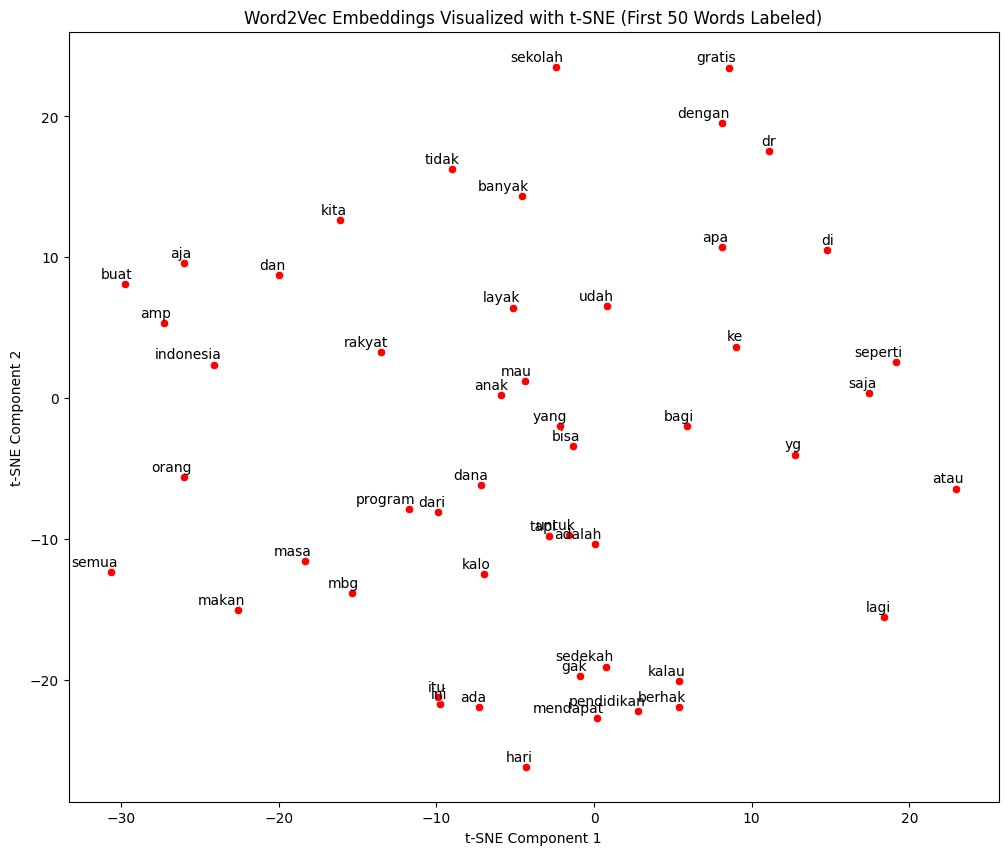

In [44]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Get the Word2Vec vectors
words = list(model.wv.index_to_key)
vectors = model.wv[words]

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
vectors_tsne = tsne.fit_transform(vectors)

# Create a DataFrame for the 2D vectors
tsne_df = pd.DataFrame(vectors_tsne, index=words, columns=['tsne1', 'tsne2'])

# Define some "feature text" words to highlight (using the first 50 words from vocabulary)
feature_words = words[:50]

# Filter the DataFrame to only include feature words
tsne_df_filtered = tsne_df.loc[feature_words]

# Plot the results
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(x='tsne1', y='tsne2', data=tsne_df_filtered, color='red') # Plotting only the filtered data in red

# Add word labels for the feature words
for word in feature_words:
    if word in tsne_df_filtered.index:
        ax.annotate(word, xy=(tsne_df_filtered.loc[word, 'tsne1'], tsne_df_filtered.loc[word, 'tsne2']),
                     xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')


plt.title('Word2Vec Embeddings Visualized with t-SNE (First 50 Words Labeled)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

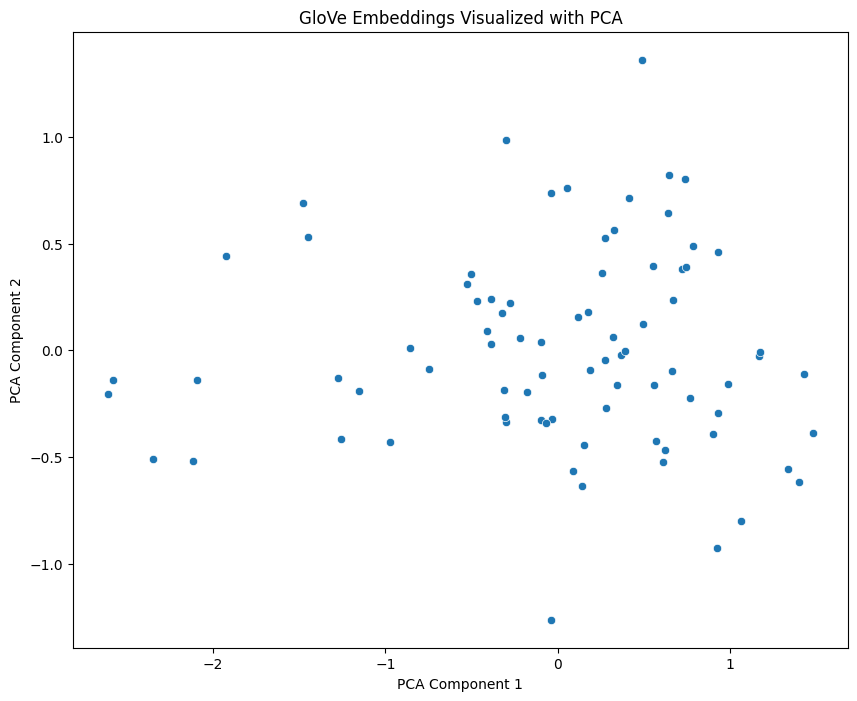

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Get the GloVe embeddings
glove_vectors = df['glove_embeddings'].tolist()

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
glove_pca = pca.fit_transform(glove_vectors)

# Create a DataFrame for the 2D vectors
glove_pca_df = pd.DataFrame(glove_pca, columns=['pca1', 'pca2'])

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', data=glove_pca_df)

plt.title('GloVe Embeddings Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

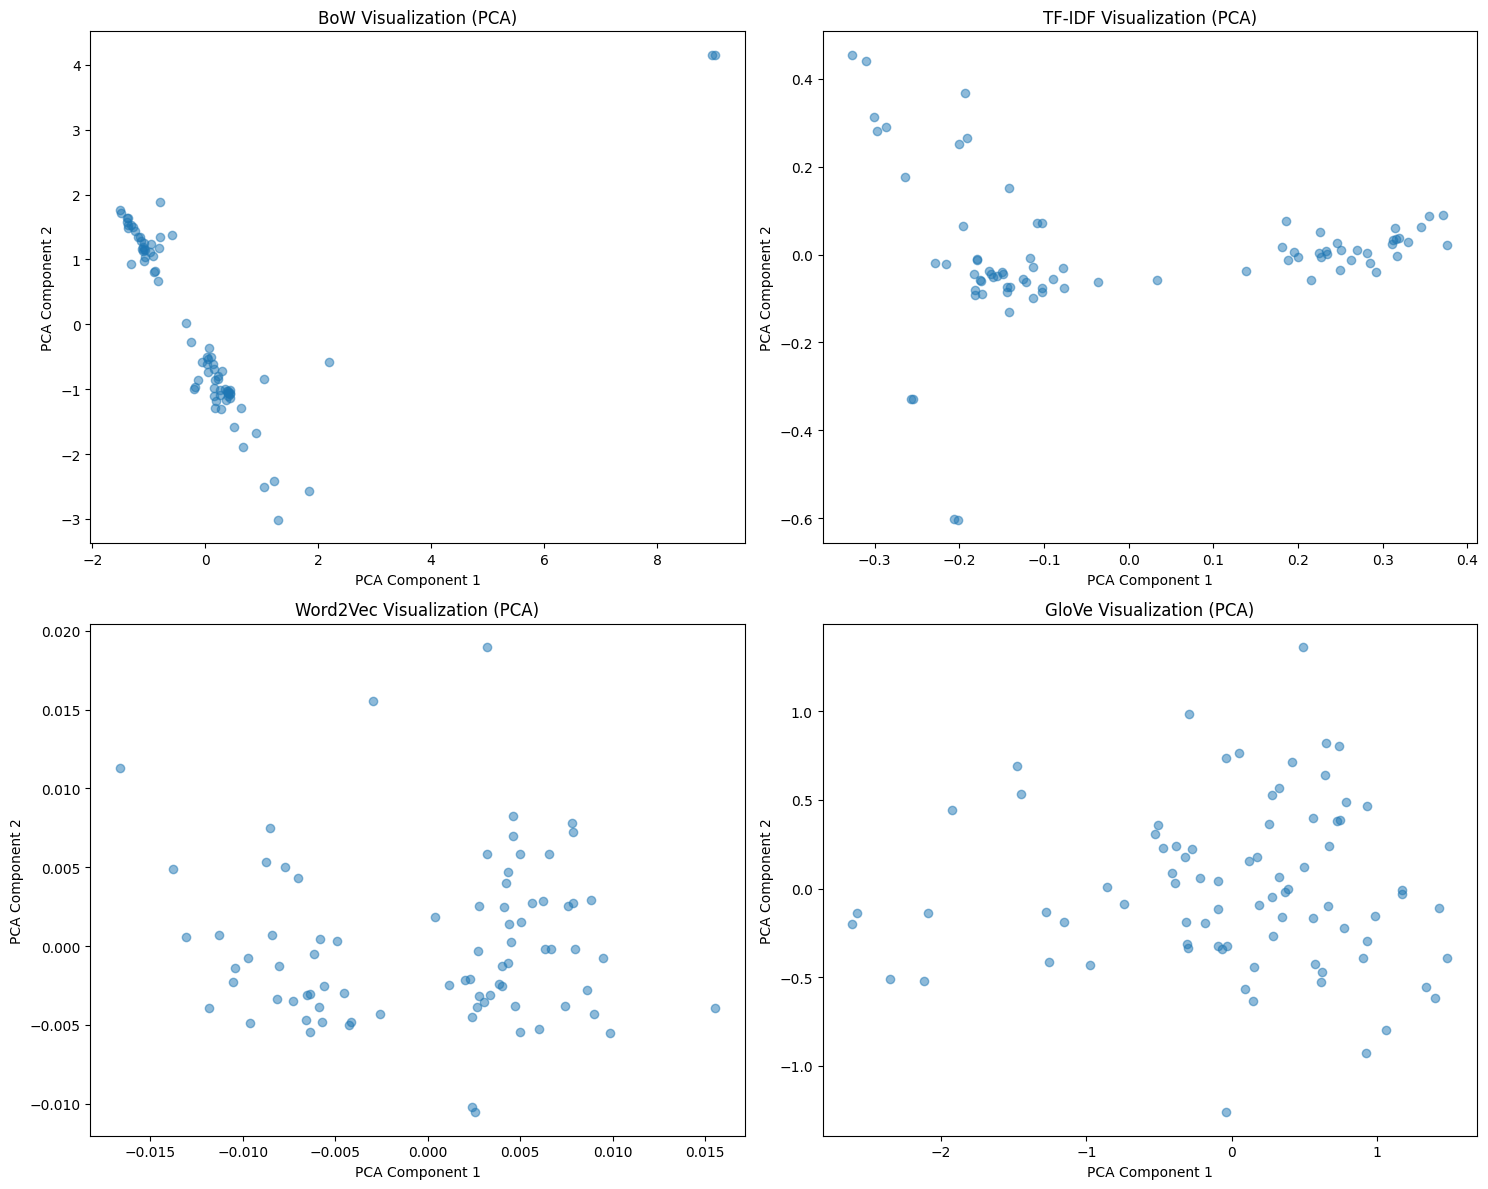

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Function to perform PCA and return 2D components
def reduce_dim_pca(data):
    pca = PCA(n_components=2)
    return pca.fit_transform(data)

# Reduce dimensionality for each representation
bow_pca = reduce_dim_pca(bow_df)
tfidf_pca = reduce_dim_pca(tfidf_df)

# For Word2Vec, we need to average the word vectors for each document
# First, handle empty tokens lists
df['tokens_cleaned'] = df['tokens'].apply(lambda x: [word for word in x if word in model.wv])
word2vec_vectors = df['tokens_cleaned'].apply(lambda x: model.wv[x].mean(axis=0) if x else [0]*model.vector_size)
word2vec_vectors = pd.DataFrame(word2vec_vectors.tolist())
word2vec_pca = reduce_dim_pca(word2vec_vectors)

# For GloVe, the embeddings are already document-level, but in list format
glove_vectors_df = pd.DataFrame(df['glove_embeddings'].tolist())
glove_pca = reduce_dim_pca(glove_vectors_df)


# Create subplots for visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

# Plot BoW
axes[0].scatter(bow_pca[:, 0], bow_pca[:, 1], alpha=0.5)
axes[0].set_title('BoW Visualization (PCA)')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# Plot TF-IDF
axes[1].scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], alpha=0.5)
axes[1].set_title('TF-IDF Visualization (PCA)')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

# Plot Word2Vec
axes[2].scatter(word2vec_pca[:, 0], word2vec_pca[:, 1], alpha=0.5)
axes[2].set_title('Word2Vec Visualization (PCA)')
axes[2].set_xlabel('PCA Component 1')
axes[2].set_ylabel('PCA Component 2')

# Plot GloVe
axes[3].scatter(glove_pca[:, 0], glove_pca[:, 1], alpha=0.5)
axes[3].set_title('GloVe Visualization (PCA)')
axes[3].set_xlabel('PCA Component 1')
axes[3].set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()